# **Modelado de tópicos**

Una vez realizada la representación de características de las reseñas obtenidas, la etapa siguiente consiste en realizar el modelamiento de tópicos, con el fin de detectar cuáles reseñas pueden ser similares, y así poder ser agrupadas por tópicos.

In [1]:
!pip install pyspark
!apt install openjdk-11-jdk-headless -qq

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
openjdk-11-jdk-headless is already the newest version (11.0.19+7~us1-0ubuntu1~20.04.1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

## **Configuración y creación de la sesión de spark**

In [3]:
conf = SparkConf().set("spark.ui.port", "4050")

sc = SparkContext(conf = conf)
spark = (
    SparkSession.builder
    .master('local[*]')
    .config("spark.driver.memory", "10g")
    .config("spark.driver.memory", "10g")
    .getOrCreate()
)

spark

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
PATH_FEATURES_OUT = r"/content/drive/Shareddrives/MSc Ciencia Datos/Mineria/features/"
PATH_FEATURES_FILE = r"amazon_features_reviews_small.parquet"
features_reviews = spark.read.parquet(PATH_FEATURES_OUT + PATH_FEATURES_FILE).cache()

In [6]:
features_reviews.printSchema()

root
 |-- review_id: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- refined_tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- num_tokens: integer (nullable = true)
 |-- tf_features: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- uid: long (nullable = true)



In [7]:
features_reviews.show(10)

+--------------+--------------------+--------------------+----------+--------------------+--------------------+---+
|     review_id|         review_body|      refined_tokens|num_tokens|         tf_features|            features|uid|
+--------------+--------------------+--------------------+----------+--------------------+--------------------+---+
|R106N066IUN8ZV|kevin kline is th...|[kevin, kline, ve...|        17|(200,[2,26,40,60,...|(200,[2,26,40,60,...|  0|
| RWT3H6HBVAL6G|y'know what this ...|[yknow, remind, s...|        63|(200,[0,2,6,11,22...|(200,[0,2,6,11,22...|  1|
| RGORN81H45NI7|this is the best ...|[best, exercis, v...|        22|(200,[3,74,77,82,...|(200,[3,74,77,82,...|  2|
|R343CPRI4MC9J0|i loved this vide...|[love, video, muc...|        19|(200,[4,6,28,29,3...|(200,[4,6,28,29,3...|  3|
|R3NK7014K996PF|was soon looking ...|[soon, look, forw...|        12|(200,[11,17,41,54...|(200,[11,17,41,54...|  4|
| ROIQI6ZW6UVL9|based on the grea...|[base, great, tra...|        21|(20

In [8]:
fr_filtered = features_reviews.filter(features_reviews['num_tokens'] > 12)

fr_filtered.sort('num_tokens').limit(30).show()

+--------------+--------------------+--------------------+----------+--------------------+--------------------+---+
|     review_id|         review_body|      refined_tokens|num_tokens|         tf_features|            features|uid|
+--------------+--------------------+--------------------+----------+--------------------+--------------------+---+
| R8CR3K90C2DAQ|on come back char...|[come, back, char...|        13|(200,[27,30,85,10...|(200,[27,30,85,10...|247|
|R1BQFLAZPTKRHM|the spring starre...|[spring, star, da...|        13|(200,[44,63,72,10...|(200,[44,63,72,10...|653|
| RHJ6RBEFUSNCN|awful version wit...|[aw, version, add...|        13|(200,[44,51,60,62...|(200,[44,51,60,62...|251|
|R1DJDFAIX3ADKV|one of my absolut...|[absolut, favorit...|        13|(200,[17,61,83,87...|(200,[17,61,83,87...|217|
| RGE05O2K1VUJM|very good movie;t...|[good, movieth, m...|        13|(200,[1,25,60,70,...|(200,[1,25,60,70,...|256|
| REJLUPCTEAEOX|i hate powerpuff ...|[hate, powerpuff,...|        13|(20

In [9]:
df_lda = features_reviews.select('uid', 'features')
df_lda.printSchema()

df_lda.show()

root
 |-- uid: long (nullable = true)
 |-- features: vector (nullable = true)

+---+--------------------+
|uid|            features|
+---+--------------------+
|  0|(200,[2,26,40,60,...|
|  1|(200,[0,2,6,11,22...|
|  2|(200,[3,74,77,82,...|
|  3|(200,[4,6,28,29,3...|
|  4|(200,[11,17,41,54...|
|  5|(200,[17,26,29,30...|
|  6|(200,[1,37,42,74,...|
|  7|(200,[6,27,35,50,...|
|  8|(200,[3,7,9,14,24...|
|  9|(200,[7,15,29,74,...|
| 10|(200,[12,14,22,25...|
| 11|(200,[0,40,51,81,...|
| 12|(200,[15,23,29,63...|
| 13|(200,[6,10,14,17,...|
| 14|(200,[1,4,5,9,21,...|
| 15|(200,[0,7,47,51,7...|
| 16|(200,[6,10,29,32,...|
| 17|(200,[5,7,64,72,8...|
| 18|(200,[0,5,17,33,4...|
| 19|(200,[4,14,29,41,...|
+---+--------------------+
only showing top 20 rows



In [10]:
df_lda_short = df_lda.limit(1000)
df_lda_short.show()

+---+--------------------+
|uid|            features|
+---+--------------------+
|  0|(200,[2,26,40,60,...|
|  1|(200,[0,2,6,11,22...|
|  2|(200,[3,74,77,82,...|
|  3|(200,[4,6,28,29,3...|
|  4|(200,[11,17,41,54...|
|  5|(200,[17,26,29,30...|
|  6|(200,[1,37,42,74,...|
|  7|(200,[6,27,35,50,...|
|  8|(200,[3,7,9,14,24...|
|  9|(200,[7,15,29,74,...|
| 10|(200,[12,14,22,25...|
| 11|(200,[0,40,51,81,...|
| 12|(200,[15,23,29,63...|
| 13|(200,[6,10,14,17,...|
| 14|(200,[1,4,5,9,21,...|
| 15|(200,[0,7,47,51,7...|
| 16|(200,[6,10,29,32,...|
| 17|(200,[5,7,64,72,8...|
| 18|(200,[0,5,17,33,4...|
| 19|(200,[4,14,29,41,...|
+---+--------------------+
only showing top 20 rows



In [11]:
from pyspark.ml.clustering import LDA

NUM_TOPICS = 10
MAX_ITERATIONS = 10

# lda = LDA(k = NUM_TOPICS, maxIter = MAX_ITERATIONS, featuresCol = 'features', seed = 1, optimizer = "em")
# lda_model = lda.fit(df_lda)
# lda_model.setSeed(1)

# reviews_modeled = lda_model.transform(df_lda)

In [12]:
# lda_topics = lda_model.describeTopics()
# lda_topics.show()

In [13]:
# reviews_modeled = lda_model.transform(features_reviews)

In [14]:
# reviews_modeled.show(10)

In [15]:
from pyspark.sql.types import IntegerType, DoubleType

def maintop(record):
    vectorlist = record.tolist()
    m = max(vectorlist)
    maintops = [i for i, j in enumerate(vectorlist) if j == m] 
    return maintops

def sorttop(record):
    vectorlist = record.tolist()
    unsorted = [(i,j) for i,j in enumerate(vectorlist)]
    maintops = [i for i,j in sorted(unsorted, key=lambda tup: -tup[1])]
    return maintops[:5]

def maintop2(record):
    return record.tolist()

udf_maintop = udf(maintop, ArrayType(DoubleType()))
udf_maintop2 = udf(maintop2, ArrayType(DoubleType()))
udf_maintop3 = udf(sorttop, ArrayType(IntegerType()))

In [16]:
# reviews_modeled_topics = reviews_modeled.withColumn("main_topics", udf_maintop3(reviews_modeled.topicDistribution))
# reviews_modeled_main_topic = reviews_modeled_topics.withColumn("main_topic", reviews_modeled_topics.main_topics[0])

In [17]:
# reviews_modeled_main_topic.show(10)

In [18]:
# reviews_modeled_main_topic.groupBy('main_topic').count().show()


## **Optimización del hiperparámetro K:**

Basados en la medida de coherencia de tópicos, se realización una optimización del hiperparámetro $k$ para el presente conjunto de datos.


In [19]:
k_values = [2, 4, 6, 8, 10]
perplexity_scores = []

for k_value in k_values:

    print(f'LDA con K = {k_value}')
    lda = LDA(k = k_value, maxIter = MAX_ITERATIONS, featuresCol = 'features', seed = 1, optimizer = "em")
    lda_model = lda.fit(df_lda)
    lda_model.setSeed(1)

    perplexity = lda_model.logPerplexity(df_lda)
    perplexity_scores.append(perplexity)

LDA con K = 2
LDA con K = 4
LDA con K = 6
LDA con K = 8
LDA con K = 10


Best k value: 2


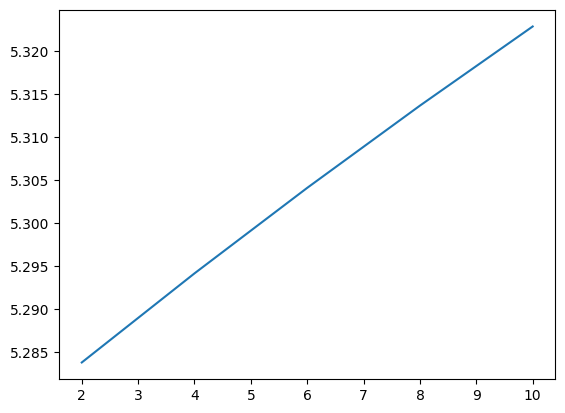

In [20]:
plt.plot(k_values, perplexity_scores)

best_k_index = perplexity_scores.index(np.min(perplexity_scores))
best_k = k_values[best_k_index]
print("Best k value:", best_k)

In [21]:
lda = LDA(k = best_k, maxIter = MAX_ITERATIONS, featuresCol = 'features', seed = 1, optimizer = "em")
lda_model = lda.fit(df_lda)
lda_model.setSeed(1)

reviews_modeled = lda_model.transform(df_lda)
lda_topics = lda_model.describeTopics()
lda_topics.show()

+-----+--------------------+--------------------+
|topic|         termIndices|         termWeights|
+-----+--------------------+--------------------+
|    0|[74, 157, 158, 13...|[0.00748321521438...|
|    1|[74, 157, 130, 15...|[0.00741884132688...|
+-----+--------------------+--------------------+



In [22]:
reviews_modeled_opi_k = lda_model.transform(features_reviews)
reviews_modeled_opi_k.show()

+--------------+--------------------+--------------------+----------+--------------------+--------------------+---+--------------------+
|     review_id|         review_body|      refined_tokens|num_tokens|         tf_features|            features|uid|   topicDistribution|
+--------------+--------------------+--------------------+----------+--------------------+--------------------+---+--------------------+
|R106N066IUN8ZV|kevin kline is th...|[kevin, kline, ve...|        17|(200,[2,26,40,60,...|(200,[2,26,40,60,...|  0|[0.50044636182885...|
| RWT3H6HBVAL6G|y'know what this ...|[yknow, remind, s...|        63|(200,[0,2,6,11,22...|(200,[0,2,6,11,22...|  1|[0.49872383113982...|
| RGORN81H45NI7|this is the best ...|[best, exercis, v...|        22|(200,[3,74,77,82,...|(200,[3,74,77,82,...|  2|[0.49929721323105...|
|R343CPRI4MC9J0|i loved this vide...|[love, video, muc...|        19|(200,[4,6,28,29,3...|(200,[4,6,28,29,3...|  3|[0.49958583758823...|
|R3NK7014K996PF|was soon looking ...|[soo

In [23]:
reviews_modeled_opi_k = reviews_modeled_opi_k.withColumn("main_topics", udf_maintop3(reviews_modeled_opi_k.topicDistribution)).cache()
reviews_modeled_opi_k = reviews_modeled_opi_k.withColumn("main_topic", reviews_modeled_opi_k.main_topics[0]).cache()

In [24]:
reviews_modeled_opi_k.show()

+--------------+--------------------+--------------------+----------+--------------------+--------------------+---+--------------------+-----------+----------+
|     review_id|         review_body|      refined_tokens|num_tokens|         tf_features|            features|uid|   topicDistribution|main_topics|main_topic|
+--------------+--------------------+--------------------+----------+--------------------+--------------------+---+--------------------+-----------+----------+
|R106N066IUN8ZV|kevin kline is th...|[kevin, kline, ve...|        17|(200,[2,26,40,60,...|(200,[2,26,40,60,...|  0|[0.50044636182885...|     [0, 1]|         0|
| RWT3H6HBVAL6G|y'know what this ...|[yknow, remind, s...|        63|(200,[0,2,6,11,22...|(200,[0,2,6,11,22...|  1|[0.49872383113982...|     [1, 0]|         1|
| RGORN81H45NI7|this is the best ...|[best, exercis, v...|        22|(200,[3,74,77,82,...|(200,[3,74,77,82,...|  2|[0.49929721323105...|     [1, 0]|         1|
|R343CPRI4MC9J0|i loved this vide...|[lo

In [25]:
reviews_modeled_opi_k.groupBy("main_topic").count().show()

+----------+-----+
|main_topic|count|
+----------+-----+
|         1|32896|
|         0|33168|
+----------+-----+



In [26]:
PATH_LDA_OUT = r"/content/drive/Shareddrives/MSc Ciencia Datos/Mineria/data/"
PATH_LDA_FILE = r"lda_reviews.parquet"
reviews_modeled_opi_k.write.mode('overwrite').parquet(PATH_LDA_OUT + PATH_LDA_FILE)

print(f'File saved into {PATH_LDA_OUT + PATH_LDA_FILE}')

File saved into /content/drive/Shareddrives/MSc Ciencia Datos/Mineria/data/lda_reviews.parquet
